### Character Prediction for Text Generation
 - Import Essential Libraries

In [0]:
from __future__ import print_function
import collections
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import numpy as np
import argparse
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Load the Training data set and build dictionary based on the characters in the training dataset.

In [0]:
data_path = "simple-examples/data/"
text = open(data_path+'ptb.char.train.txt', 'rb').read().decode(encoding='utf-8')
vocab = sorted(set(text))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

#### The Training, Validation and Test Datasets are converted into numeric format using the dictionary.

In [0]:
train_data = np.array([char2idx[c] for c in text])

In [0]:
valid_text = open(data_path+'ptb.char.valid.txt', 'rb').read().decode(encoding='utf-8')
valid_data = np.array([char2idx[c] for c in valid_text])

In [0]:
test_text = open(data_path+'ptb.char.test.txt', 'rb').read().decode(encoding='utf-8')
test_data = np.array([char2idx[c] for c in test_text])

The training and validation datasets are segregated into batch-sizes when processed by the recurrent neural network.

In [0]:
class KerasBatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        self.current_idx = 0
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    self.current_idx = 0
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
                y[i, :, :] = to_categorical(temp_y, num_classes=self.vocabulary)
                self.current_idx += self.skip_step
            yield x, y

#### Hyper-parameters chosen for the model are
 - number of steps = 50
 - embedding size = 512
 - batch size = 50
 - vocabulary length = 51
 - number of epochs = 6
 - optimizer = Adam

In [0]:
num_steps = 50
batch_size = 50
embed_size = 512
vocab_length = len(vocab)

In [0]:
print(vocab_length)

51


In [0]:
train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, vocab_length)
valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocab_length)

#### Recurrent Neural Network Model with two Long-short term memory (LSTM) cells is built for text generation.

In [0]:
model = Sequential()
model.add(Embedding(vocab_length, embed_size, input_length=num_steps))
model.add(LSTM(embed_size, return_sequences=True))
model.add(LSTM(embed_size, return_sequences=True))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(vocab_length)))
model.add(Activation('softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Perplexity - Model Metric
- It is a measurement of how well a probability distribution or probability model predicts a sample

In [0]:
def perplexity(y_true, y_pred):
    return K.pow(2.0, K.mean(K.categorical_crossentropy(y_true, y_pred)))

In [0]:
import keras.backend as K
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',perplexity])

In [0]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 512)           26112     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 512)           2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 512)           2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 51)            26163     
_________________________________________________________________
activation_1 (Activation)    (None, 50, 51)            0         
Total params: 4,250,675
Trainable params: 4,250,675
Non-trainable params: 0
____________________________________________

In [0]:
checkpointer = ModelCheckpoint(filepath='/model-{epoch:02d}.hdf5', verbose=1)

#### Model Training-Phase using the training and validation dataset.


In [0]:
num_epochs = 6
train_steps = len(train_data)//(batch_size*num_steps)
valid_steps=len(valid_data)//(batch_size*num_steps)
hist = model.fit_generator(train_data_generator.generate(), train_steps, num_epochs,
                    validation_data=valid_data_generator.generate(),
                    validation_steps=valid_steps, callbacks=[checkpointer])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/6





4013/4013 [==============================] - 1078s 269ms/step - loss: 1.0785 - categorical_accuracy: 0.6965 - perplexity: 2.1727 - val_loss: 0.8352 - val_categorical_accuracy: 0.7487 - val_perplexity: 1.7940

Epoch 00001: saving model to /model-01.hdf5
Epoch 2/6
4013/4013 [==============================] - 1076s 268ms/step - loss: 0.8572 - categorical_accuracy: 0.7587 - perplexity: 1.8638 - val_loss: 0.7860 - val_categorical_accuracy: 0.7634 - val_perplexity: 1.7272

Epoch 00002: saving model to /model-02.hdf5
Epoch 3/6
4013/4013 [==============================] - 1078s 269ms/step - loss: 0.8007 - categorical_accuracy: 0.7720 - perplexity: 1.7909 - val_loss: 0.7139 - val_categorical_accuracy: 0.7845 - val_perplexity: 1.6437

Epoch 00003: saving model to /model-03.hdf5
Epoch 4/6
4013/4013 [==============================] - 1077s 268ms/step - loss: 0.7948 - categorical_accuracy

In [0]:
model.save("final_model.hdf5")

##### Plot of Perplexity v/s Epochs - for training and validation dataset.

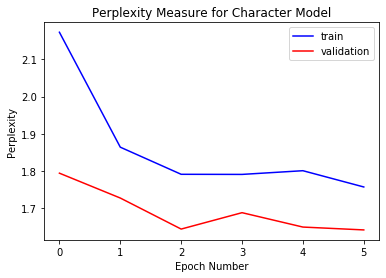

In [0]:
plt.plot(hist.history['perplexity'], 'b')
plt.plot(hist.history['val_perplexity'], 'r')
plt.title('Perplexity Measure for Character Model')
plt.ylabel('Perplexity')
plt.xlabel('Epoch Number')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

##### Plot of Accuracy v/s Epochs - for training and validation dataset.

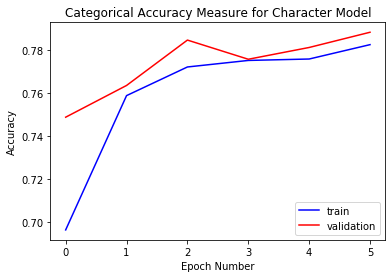

In [0]:
plt.plot(hist.history['categorical_accuracy'], 'b')
plt.plot(hist.history['val_categorical_accuracy'], 'r')
plt.title('Categorical Accuracy Measure for Character Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Number')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

##### Plot of Loss v/s Epochs - for training and validation dataset.

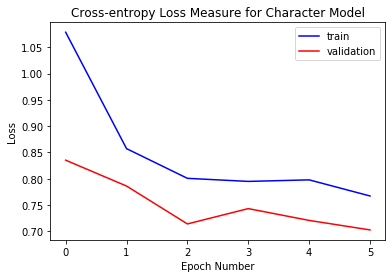

In [0]:
plt.plot(hist.history['loss'], 'b')
plt.plot(hist.history['val_loss'], 'r')
plt.title('Cross-entropy Loss Measure for Character Model')
plt.ylabel('Loss')
plt.xlabel('Epoch Number')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#### Performing Character Model prediction on the test dataset for text generation.

In [0]:
iterations = 200
test_prediction_generator = KerasBatchGenerator(test_data, num_steps, 1, vocab_length,skip_step=1)
num_predict = 400
true_print_out = "Actual chars: "
pred_print_out = "Predicted chars: "
for i in range(num_predict):
    data = next(test_prediction_generator.generate())
    prediction = model.predict(data[0])
    predict_char = np.argmax(prediction[:, num_steps - 1, :])
    predict_char = predict_word
    true_print_out += idx2char[test_data[num_steps + iterations + i]]
    pred_print_out += idx2char[predict_char]
print(true_print_out.replace("_", " "))
print(pred_print_out.replace("_", " "))

Actual chars: e   p l u n g e d   N   p o i n t s   m o s t   o f   i t   i n   t h e   f i n a l   h o u r   i t   b a r e l y   m a n a g e d   t o   s t a y   t h i s   s i d e   o f   c h a o s 
 s o m e   c i r c u i t   b r e a k e r s   i n s t a l l e d   a f t e r   t h e   o c t o b e r   N   c r a s h   f a i l e d   t h e i r   f i r s t   t e s t   t r a d e r s   s a y   u n a b l e   t o   c o o 
Predicted chars:                                                                                                                                                                                                                                                                                                                                                                                                                 
